In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurokit2 as nk
import random


from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from matplotlib import gridspec


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn import preprocessing



##### 1 iteration #####
##### 2 iteration #####
##### 3 iteration #####
[[30]
 [50]
 [90]]
[ -339    97 -1516]
next stiffness parameter: [1.]
after fit: RBF(length_scale=86.8) + WhiteKernel(noise_level=0.179)
log-likelihood: -3.0911931438856524

##### 4 iteration #####
[[30.]
 [50.]
 [90.]
 [ 1.]]
[ -339.    97. -1516. -2328.]
next stiffness parameter: [1.]
after fit: RBF(length_scale=100) + WhiteKernel(noise_level=0.178)
log-likelihood: -3.6715976499234895

##### 5 iteration #####
[[30.]
 [50.]
 [90.]
 [ 1.]
 [ 1.]]
[ -339.    97. -1516. -2328. -2311.]
next stiffness parameter: [100.]
after fit: RBF(length_scale=51.6) + WhiteKernel(noise_level=0.01)
log-likelihood: -1.1614718094465228

##### 6 iteration #####
[[ 30.]
 [ 50.]
 [ 90.]
 [  1.]
 [  1.]
 [100.]]
[ -339.    97. -1516. -2328. -2311. -2432.]
next stiffness parameter: [50.]
after fit: RBF(length_scale=58.9) + WhiteKernel(noise_level=0.01)
log-likelihood: -0.16336336073985702

##### 7 iteration #####
[[ 30.]
 [ 50.]
 [ 90.]
 [ 

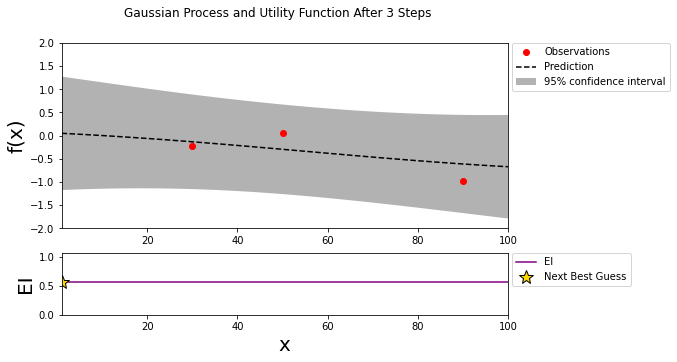

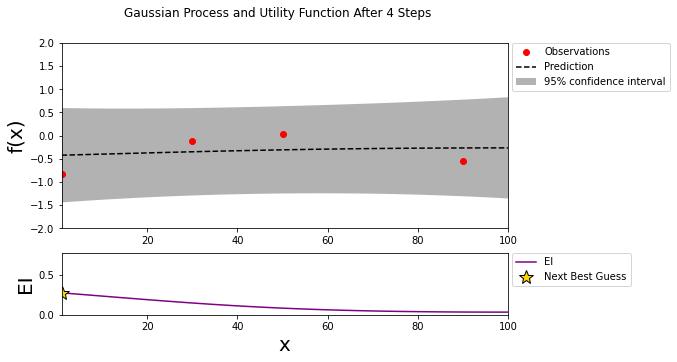

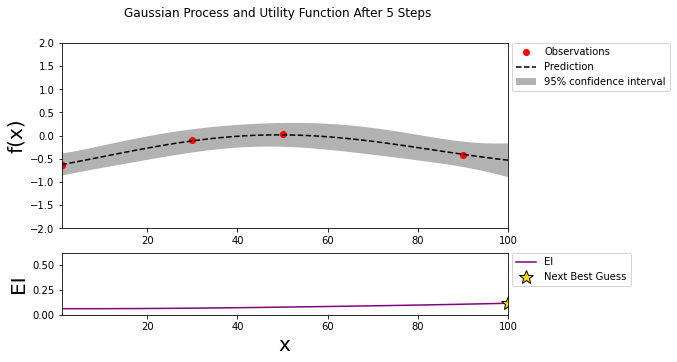

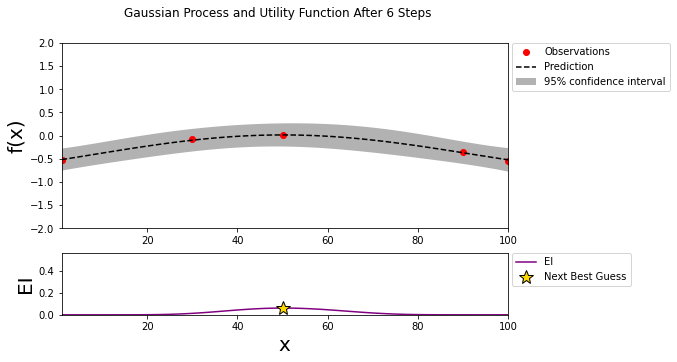

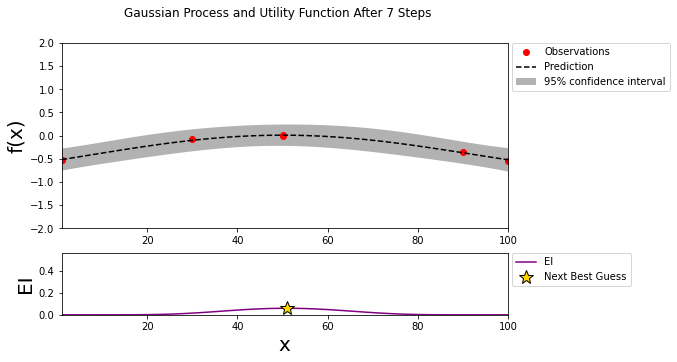

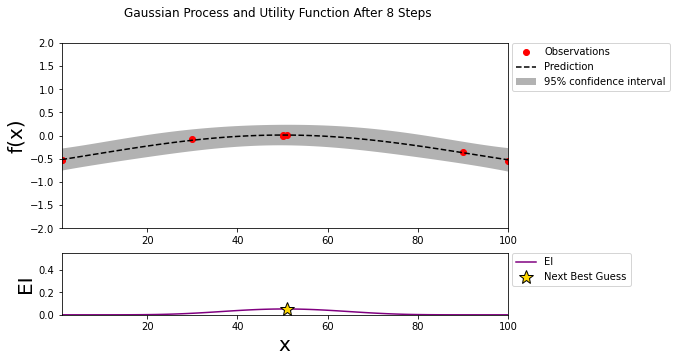

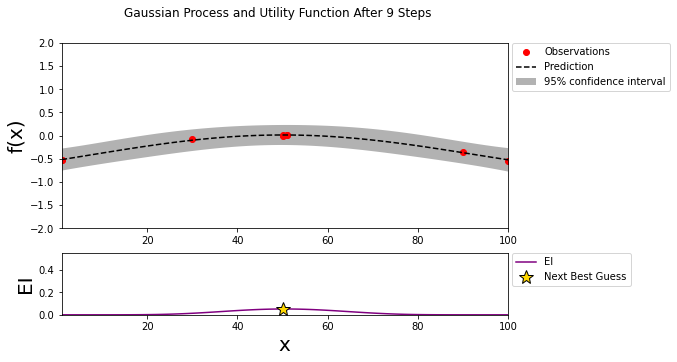

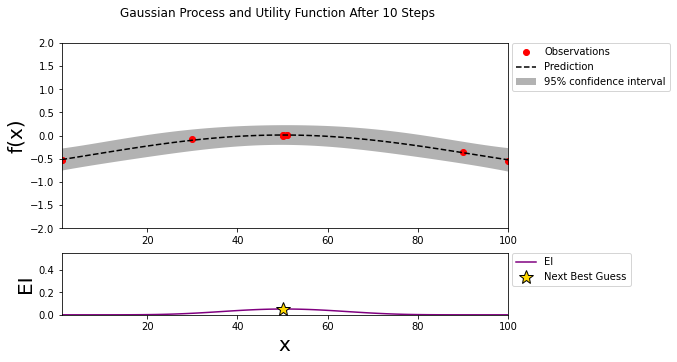

In [3]:

step = 0

def target(r): 
    #noise = random.uniform(0, 1)
    noise = random.randint(0, 100)
    return (-(r - 50)**2) + noise


def make_plot(x_obs, y_obs, grid, sigma, mu, utility):
    
    
    fig = plt.figure(figsize=(8, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(step),
        fontdict={'size':70}
    )
    
    axis.plot(x_obs.flatten(), y_obs, 'o', markersize=6, label=u'Observations', color='r')
    axis.plot(grid, mu, '--', color='k', label='Prediction')
   

    axis.fill(np.concatenate([grid, grid[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='gray', ec='None', label='95% confidence interval')
    
    axis.set_xlim((1, 100))
    axis.set_ylim((-2, 2))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    acq.plot(grid, utility, label='EI', color='purple')
    acq.plot(grid[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    
    
    print('next stiffness parameter:',grid[np.argmax(utility)])
    
    acq.set_xlim((1, 100))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('EI', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    

def posterior(optimizer, x_obs, y_obs, grid):
   
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


optimizer = BayesianOptimization(
    f=None,
    pbounds={'x': (1, 100)},
    verbose=1,
    random_state=1,
)

grid = np.linspace(1, 100, 100).reshape(-1, 1)

tmin_data = []
rm_arr = []
stif_arr = [30,50,90]


kernel = RBF(length_scale=50, length_scale_bounds=(0.01, 100.0)) + WhiteKernel(noise_level = 1, noise_level_bounds=(0.01, 100.0))
optimizer._gp = GaussianProcessRegressor(kernel=kernel,random_state=0)


for i in range(10) :
    print('##### {} iteration #####'.format(len(rm_arr)+1))

    if i < 2:
        r = stif_arr[i]
        rval = target(r)
        rm_arr.append(rval)
        continue

    elif i >= 2 : 
        if i == 2:
            r = stif_arr[i]
        else:
            r = stif_arr[i]
                
           
        rval = target(r)
        rm_arr.append(rval)

        x_obs = np.array(stif_arr).reshape(-1,1)
        y_obs = np.array(rm_arr)
        print(x_obs)
        print(y_obs)
    
        normalized_arr = preprocessing.normalize([y_obs])
        y_obs = normalized_arr[0]

#         print('x', x_obs)
#         print('y', normalized_arr)
        
        
        utility_function = UtilityFunction(kind="ei", kappa=5, xi=0)
        utility = utility_function.utility(grid, optimizer._gp, 0)
        
        mu, sigma = posterior(optimizer, x_obs, y_obs, grid)
        next_ = grid[np.argmax(utility)][0]
        stif_arr.append(next_)
        step = i+1
        
        make_plot(x_obs, y_obs, grid, sigma, mu, utility)
        plt.savefig('{}_iteration_n.jpg'.format(i+1))
        
        print('after fit:',optimizer._gp.kernel_)        
        
        
        
        print('log-likelihood:',optimizer._gp.log_marginal_likelihood(optimizer._gp.kernel_.theta))
        
        print('')
        
for h in optimizer._gp.kernel_.hyperparameters:
    print(h)

        
